# DTSA 5511 Introduction to Deep Learning Final Project
### Topic: Image Classification with Convolutional Neural Networks on Vehicle Dataset

## Background

In this final project, we are going to build models to classify images of vehicles. The dataset we are going to use is the [Kaggle Vehicle Dataset](https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition/data). The goal of this project is to build a CNN model that can classify images of vehicles into the correct class.

This project has the incentive to explore the application of deep learning in image classification. The dataset is relatively small, which makes it a good starting point for beginners to practice building CNN models.

Besides, upon finishing the model, it can be further developed into a vehicle recognition system that can be used in real-world applications, such as traffic monitoring, vehicle tracking, and security surveillance.

## Identify a Deep Learning Problem

The problem we are going to solve is a multi-class classification problem. We are going to build a CNN model that can classify images of vehicles into the correct class. The dataset contains images of 4 classes of vehicles: car, truck, bus, motocycle. The model will take an image as input and output the class of the vehicle in the image.

In other works of Kaggle site, most kernels up there are using single type of CNN model, such as VGG16, ResNet, Inception, etc. In this project, we are going to explore different CNN models and compare their performance on the vehicle dataset. It serves as a challenge for me to learn and understand the differences between different CNN models and how they perform on different datasets, as I am still a beginner in deep learning.

## Import Libraries

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import cv2
import random
import PIL
from PIL import Image
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Nadam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import keras_tuner as kt
from keras_tuner import RandomSearch

## Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

In [13]:
# Import data

data_dir = 'Dataset'
class_names = os.listdir(data_dir)
num_classes = len(class_names)

first_class_dir = os.path.join(data_dir, class_names[0])
first_image_path = os.path.join(first_class_dir, os.listdir(first_class_dir)[0])
sample_image = cv2.imread(first_image_path)
image_height, image_width, image_channels = sample_image.shape

In [14]:
print("Class count:", num_classes)
print("height:", image_height, "width:", image_width, "channels:", image_channels)

Class count: 4
height: 400 width: 600 channels: 3


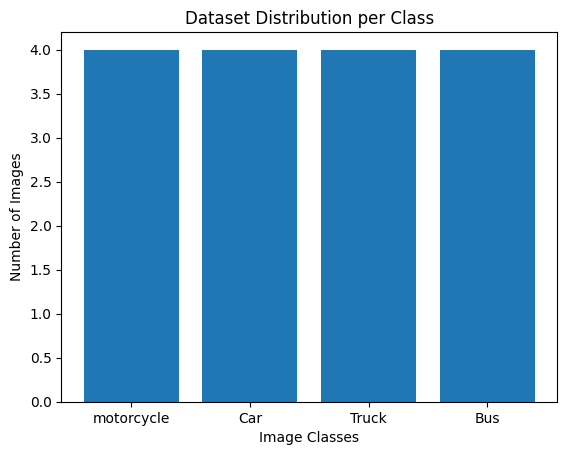

In [5]:
plt.bar(class_names, 4)
plt.xlabel('Image Classes')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution per Class')
plt.show()

Per barplot, the data is evenly distributed between the 4 classes. The data is not imbalanced.
### Image preview - What does the images look like?

In [15]:
# Function to display image samples from a dataset
def display_image_samples(data_dir, class_names, num_samples_per_class):
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        image_filenames = os.listdir(class_path)
        random.shuffle(image_filenames)
        
        fig, axs = plt.subplots(1, num_samples_per_class, figsize=(12, 4))
        
        for i in range(num_samples_per_class):
            image_path = os.path.join(class_path, image_filenames[i])
            sample_image = cv2.imread(image_path)
            sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
            
            axs[i].imshow(sample_image)
            axs[i].axis('off')
            axs[i].set_title(f'Sample {i+1}')
        
        fig.suptitle(class_name, fontsize=14, fontweight='bold')
        plt.show()

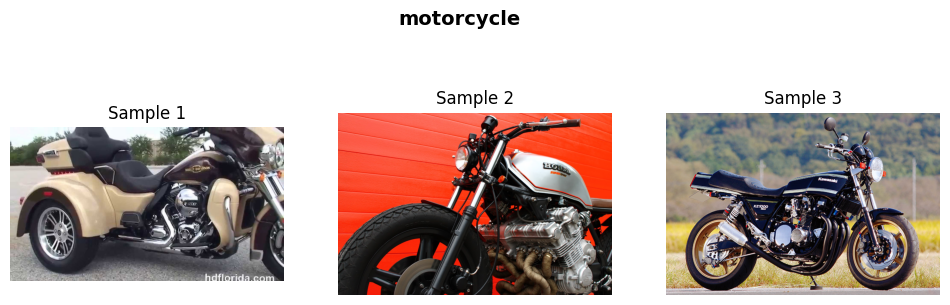

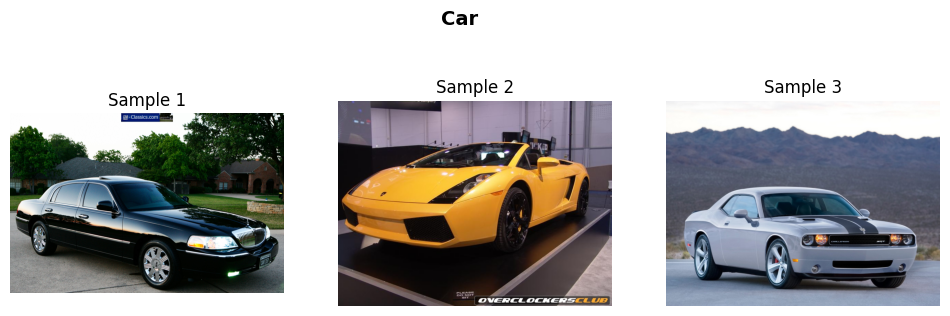

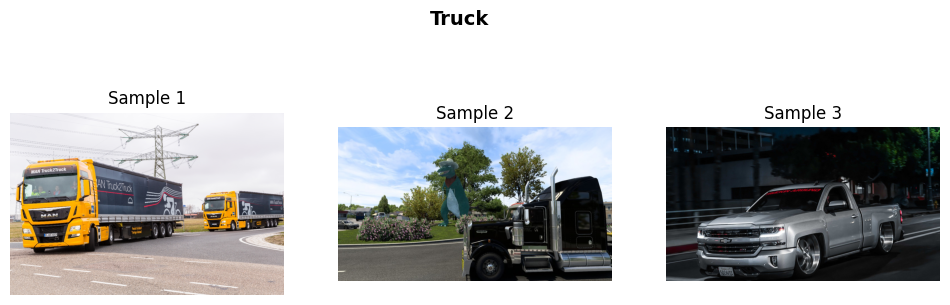

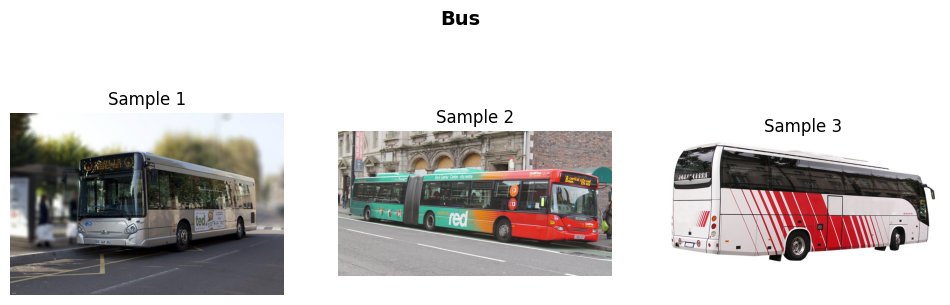

In [8]:
data_dir = 'Dataset'
num_samples_per_class = 3

class_names = os.listdir(data_dir)

display_image_samples(data_dir, class_names, num_samples_per_class)

Per inspection, images are:
- From various sources and various dimensions
- not preprocessed and are in their raw form
- not in grayscale and are in RGB format
- not normalized and are in their raw pixel values

Correlations between dataset: non-existent, as per observation the images are not related to each other between classes.

In [3]:
# Function to obtain image dimension statistics
def get_image_stats(data_dir, class_names):
    image_stats = []

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        image_filenames = os.listdir(class_path)

        for image_filename in image_filenames:
            image_path = os.path.join(class_path, image_filename)
            image = cv2.imread(image_path)
            image_stats.append(image.mean(axis=(0, 1)))

    image_stats = np.array(image_stats)
    mean_stats = image_stats.mean(axis=0)
    std_stats = image_stats.std(axis=0)

    print("Mean pixel values:", mean_stats)
    print("Standard deviation of pixel values:", std_stats)

In [4]:
get_image_stats(data_dir, class_names)

Mean pixel values: [114.06713775 118.03303583 123.34488098]
Standard deviation of pixel values: [41.74682924 39.56793569 40.1888138 ]


## Data Preprocessing
In order to feed the images into the CNN model (and other pre-trained models), we need to preprocess the images by resizing them to a fixed size, normalizing the pixel values.

For models like ResNet-50, a common input size is 224x224 pixels. This size is a good balance between detail and computational efficiency.

Then split the data into training, validation and testing sets.

In [16]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    try:
        # Try loading with Pillow first (better at handling different formats)
        with Image.open(image_path) as img:
            # Convert to RGB, removing transparency
            if img.mode in ('RGBA', 'LA'):
                background = Image.new('RGB', img.size, (255, 255, 255))
                background.paste(img, mask=img.split()[-1])
                img = background
            
            # Convert to RGB mode
            img = img.convert('RGB')
            
            # Resize image
            img = img.resize(target_size, PIL.Image.LANCZOS)
            
            # Convert to numpy array
            img_array = np.array(img)
            
            return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def create_image_dataframe(data_dir):
    image_paths = []
    image_labels = []
    
    # Validate data directory
    if not os.path.exists(data_dir):
        raise ValueError(f"Directory {data_dir} does not exist")
    
    # Get class names, excluding hidden files/directories
    class_names = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d)) 
                   and not d.startswith('.')]
    
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")
    
    # Collect image paths and labels
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        
        # Get image files, excluding hidden files
        image_filenames = [f for f in os.listdir(class_path) 
                           if os.path.isfile(os.path.join(class_path, f)) 
                           and not f.startswith('.')]
        
        for image_filename in image_filenames:
            image_path = os.path.join(class_path, image_filename)
            
            # Optional: Add image validation
            try:
                # Quick check if image is valid
                img = Image.open(image_path)
                img.verify()
            except Exception as e:
                print(f"Skipping invalid image: {image_path}")
                continue
            
            image_paths.append(image_path)
            image_labels.append(class_name)
    
    # Create DataFrame
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': image_labels
    })
    
    return df, class_names

In [17]:
def create_data_generators(df, image_size=(224, 224), batch_size=32):
    # Split the dataframe
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
    valid_df, test_df = train_test_split(dummy_df, train_size=0.6, shuffle=True, random_state=42)
    
    # Create advanced data generator
    data_generator = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,  # Use model-specific preprocessing
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False
    )
    
    # Create generators
    generators = {}
    for name, dataframe in [('train', train_df), ('valid', valid_df), ('test', test_df)]:
        generators[name] = data_generator.flow_from_dataframe(
            dataframe,
            directory=None,
            x_col='image_path',
            y_col='label',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
            # color_mode='rgb',
            shuffle=(name != 'test')
        )
    
    return generators

In [18]:
data_dir = 'Dataset'
image_size = (224, 224)
batch_size = 32

# Create DataFrame
df, class_names = create_image_dataframe(data_dir)

# Validate DataFrame
print(f"Total images: {len(df)}")
print(f"Class distribution:\n{df['label'].value_counts()}")

# Create generators
generators = create_data_generators(df, image_size, batch_size)

# Optional: Print class indices
print("Class Indices:", generators['train'].class_indices)
df.head()

Found 4 classes: ['motorcycle', 'Car', 'Truck', 'Bus']
Total images: 400
Class distribution:
label
motorcycle    100
Car           100
Truck         100
Bus           100
Name: count, dtype: int64
Found 320 validated image filenames belonging to 4 classes.
Found 48 validated image filenames belonging to 4 classes.
Found 32 validated image filenames belonging to 4 classes.
Class Indices: {'Bus': 0, 'Car': 1, 'Truck': 2, 'motorcycle': 3}


,image_path,label
0,Dataset/motorcycle/Image_26.jpg,motorcycle
1,Dataset/motorcycle/Image_97.JPG,motorcycle
2,Dataset/motorcycle/Image_71.jpg,motorcycle
3,Dataset/motorcycle/Image_49.jpg,motorcycle
4,Dataset/motorcycle/Image_85.jpeg,motorcycle


In [5]:
# Allocate generators

train_generator = generators['train']
validation_generator = generators['valid']
test_generator = generators['test']

# Set the seed for reproducibility
np.random.seed(420)
tf.random.set_seed(1)
channels = 3

### Function to create plot for evaluating model performance

In [6]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

## Main Analysis

In our comprehensive investigation of vehicle image classification, we employed a multi-model approach leveraging state-of-the-art transfer learning techniques to achieve robust classification performance. 
Our first model will be a homebrew CNN model as a baseline. Then we will explore the performance of pre-trained models including ResNet50, MobileNetV2, and EfficientNetB0.

Upon evaluating from the accuracies and losses of different model, we would evaluate the best model to be used for the vehicle image classification and the reasons behind it.

Next we would perform hyperparameter tuning on the best model to further improve the model performance, and evaluate the model performance using our testing set.

The hyperparameter search space consists of difference design choices such as pooling strategies (global average vs. flatten), activation functions (ReLU, ELU), and optimizer selections (Adam, RMSprop), enabling a comprehensive exploration of model design space.

Note: This project was conducted on a personal computer with limited computational resources. As a result, most training process and the hyperparameter tuning process was conducted with a limited search space. As the purpose of the project was to explore the application of deep learning in image classification, the hyperparameter tuning process was not exhaustive.

## Model architectures
### Homebrew CNN

We will start with a simple CNN model as baseline.

In [8]:
# Define the CNN model architecture
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])
cnn_model.summary()


/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740837215.833762   12953 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 824ms/step - accuracy: 0.4590 - loss: 1.2497 - val_accuracy: 0.3958 - val_loss: 1.2207
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 696ms/step - accuracy: 0.5509 - loss: 1.1038 - val_accuracy: 0.5208 - val_loss: 1.0918
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 688ms/step - accuracy: 0.5464 - loss: 1.0850 - val_accuracy: 0.3958 - val_loss: 1.3929
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 757ms/step - accuracy: 0.5060 - loss: 1.1633 - val_accuracy: 0.6042 - val_loss: 0.9587
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 703ms/step - accuracy: 0.5553 - loss: 1.0893 - val_accuracy: 0.5625 - val_loss: 1.1422
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 717ms/step - accuracy: 0.5136 - loss: 1.1056 - val_accuracy: 0.5417 - val_loss: 1.0336
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 881ms/step - accuracy: 0.5341 - loss: 1.1172 - val_accuracy: 0.5417 - val_loss: 1.0125
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 751ms/step - accuracy: 0.5219 - loss: 1.0847 - val_accuracy: 0

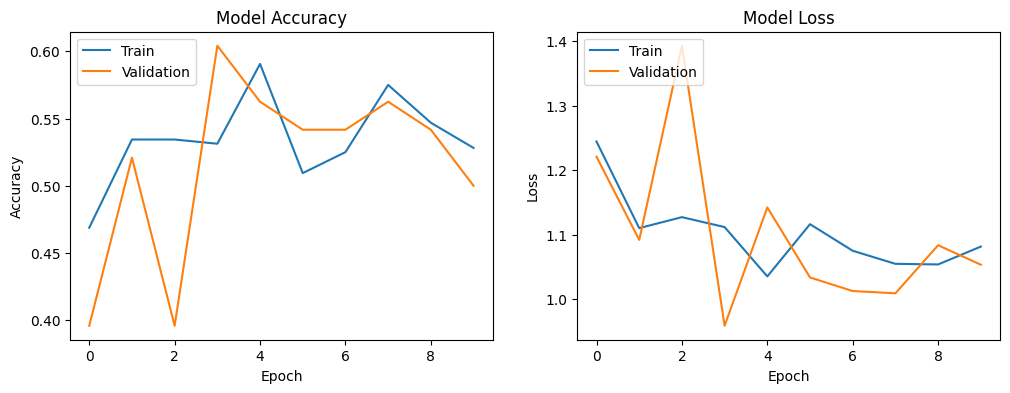

: 

In [ ]:
# Compile the model
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

# Train the model
history = cnn_model.fit(train_generator,epochs=10,validation_data=validation_generator)
plot_training_history(history)

From the plot, we can see that the model is not generalizing well to the validation set as the accuracy is not increasing and the loss is not decreasing. This indicates that the model is overfitting to the training set.

### CNN with increased depth
We will increase the depth of the CNN model to see if it can improve the model performance.

In [9]:
# Increased depth of CNN
cnn_model_more_depth = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, channels)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])
cnn_model_more_depth.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,652 (19.48 MB)

 Trainable params: 5,107,652 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
cnn_model_more_depth.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

# Train the model
history = cnn_model_more_depth.fit(train_generator,epochs=10,validation_data=validation_generator)

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
I0000 00:00:1740837245.360957   13206 service.cc:148] XLA service 0x7f9f94002890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740837245.361477   13206 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-01 21:54:05.425215: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740837245.689845   13206 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2188 - loss: 1.5132

I0000 00:00:1740837251.845888   13206 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2242 - loss: 1.4894 - val_accuracy: 0.2292 - val_loss: 1.3940
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 681ms/step - accuracy: 0.2616 - loss: 1.3820 - val_accuracy: 0.2292 - val_loss: 1.3885
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 873ms/step - accuracy: 0.2321 - loss: 1.3858 - val_accuracy: 0.3958 - val_loss: 1.3781
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 796ms/step - accuracy: 0.3400 - loss: 1.3797 - val_accuracy: 0.2083 - val_loss: 1.3817
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 632ms/step - accuracy: 0.3164 - loss: 1.3578 - val_accuracy: 0.2083 - val_loss: 1.4230
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 681ms/step - accuracy: 0.3245 - loss: 1.3553 - val_accuracy: 0.2708 - val_loss: 1.3452
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 620ms/step - accuracy: 0.3582 - loss: 1.3390 - val_accuracy: 0.4375 - val_loss: 1.3025
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 766ms/step - accuracy: 0.3319 - loss: 1.2970 - val_accuracy: 0.4167 - val_lo

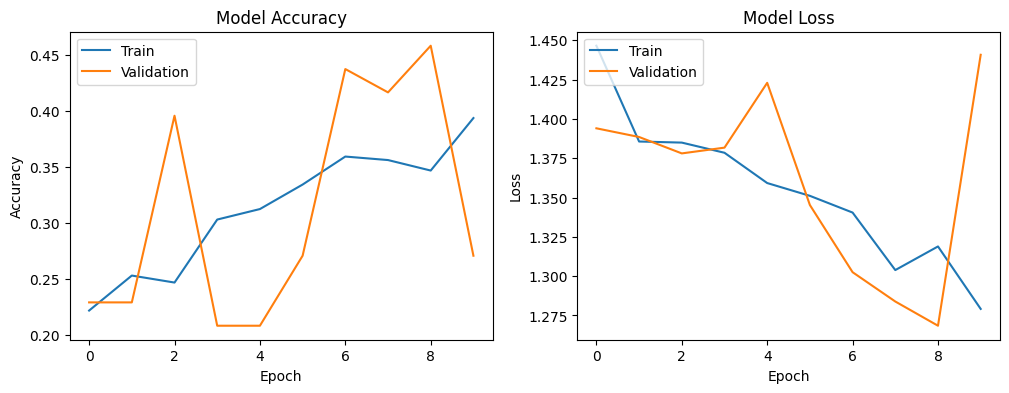

In [13]:
plot_training_history(history)

Not much improvement in the model performance. Overall the increased amount of depth further "confuse" the model and the model is not able to generalize well to the validation set.

### CNN Model with Batch Normalization
We will add batch normalization to the CNN model to see if it can improve the model performance.

In [19]:
cnn_model_normalized = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, channels)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='softmax')
])

# Compile and train the model
cnn_model_normalized.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = cnn_model_normalized.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.2383 - loss: 16.6604 - val_accuracy: 0.2083 - val_loss: 79.5524
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2811 - loss: 8.6144 - val_accuracy: 0.2917 - val_loss: 14.2521
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.2765 - loss: 3.2131 - val_accuracy: 0.2083 - val_loss: 2.2594
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2757 - loss: 2.0406 - val_accuracy: 0.3125 - val_loss: 1.3783
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2721 - loss: 1.4902 - val_accuracy: 0.2500 - val_loss: 2.2230
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 983ms/step - accuracy: 0.2775 - loss: 1.5055 - val_accuracy: 0.2083 - val_loss: 1.4882
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2593 - loss: 1.4234 - val_accuracy: 0.2083 - val_loss: 1.3941
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.3360 - loss: 1.4876 - val_accuracy: 0.1667 - val

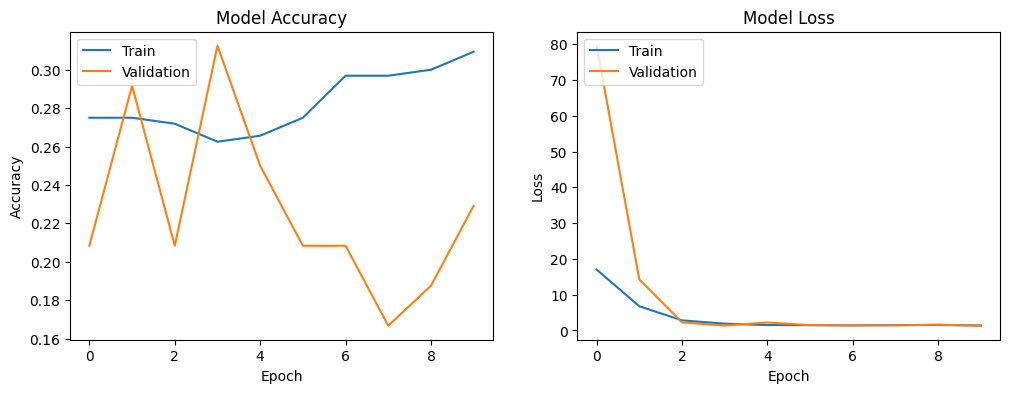

In [20]:
plot_training_history(history)

Normalisation does not improve the model performance.

The possible reason that our homebrew CNN is not performing well is that the dataset is relatively small. The model is too complex for the small dataset, which leads to overfitting. We will try to use a pre-trained model to see if it can improve the model performance.

## Pre-trained model
Below I have chosen a couple of pre-trained models to use for transfer learning. I will use the pre-trained models to extract features from the images and then use these features to train a classifier.

Advantages of using pre-trained models:
- Pre-trained models have already been trained on large datasets and have learned features that are useful for a wide range of tasks.
- Using pre-trained models can save time and computational resources.

Therefore, I will experiment with different pre-trained models to see which one works best for this task.

1. ResNet50
2. EfficentNet
2. MobileNetV2

### ResNet50

In [19]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, channels), pooling='avg')

resnet_model = Sequential(
    [base_model,
     Flatten(),
     Dense(128, activation='relu'),
     Dense(len(class_names), activation='softmax')]
)

resnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 23,797,380 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10


2025-03-02 02:21:58.850714: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5009_0', 112 bytes spill stores, 224 bytes spill loads

2025-03-02 02:21:59.341993: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7800', 24 bytes spill stores, 24 bytes spill loads

2025-03-02 02:21:59.800884: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5009', 220 bytes spill stores, 576 bytes spill loads

2025-03-02 02:22:00.120906: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7800', 60 bytes spill stores, 64 bytes spill loads



10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2595 - loss: 1.4479 - val_accuracy: 0.4792 - val_loss: 1.3062
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 699ms/step - accuracy: 0.2950 - loss: 1.3627 - val_accuracy: 0.3958 - val_loss: 1.2693
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 740ms/step - accuracy: 0.3865 - loss: 1.2633 - val_accuracy: 0.3333 - val_loss: 1.4345
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - accuracy: 0.3375 - loss: 1.2890 - val_accuracy: 0.4375 - val_loss: 1.2616
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 750ms/step - accuracy: 0.4269 - loss: 1.2511 - val_accuracy: 0.4792 - val_loss: 1.1645
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 730ms/step - accuracy: 0.3970 - loss: 1.2348 - val_accuracy: 0.5000 - val_loss: 1.1573
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 755ms/step - accuracy: 0.5137 - loss: 1.2169 - val_accuracy: 0.6042 - val_loss: 1.0983
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.4614 - loss: 1.3096 - val_accuracy: 0.3958 - val_lo

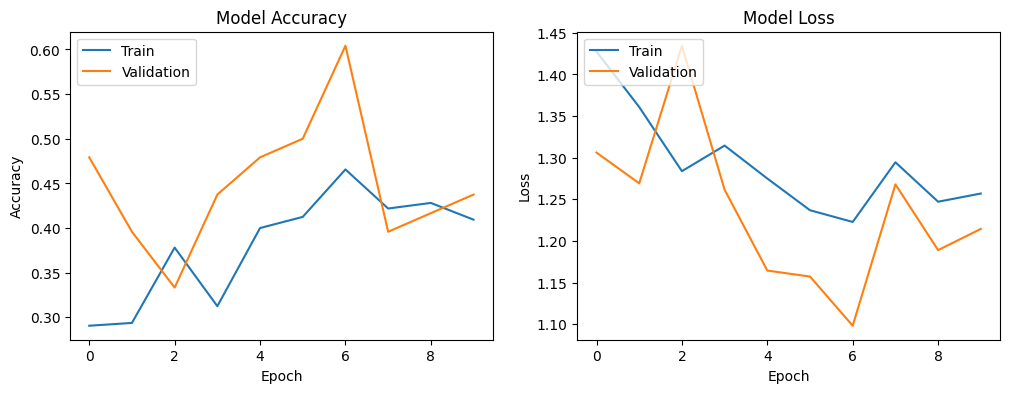

: 

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model and store the training history
history = resnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# Call the function to plot the training history
plot_training_history(history)

This model does not have a good performance on the vehicle dataset. The model is not able to generalize well to the validation set.

### EfficientNet
The EfficientNet model is used for transfer learning. The model is trained on the ImageNet dataset and has been shown to achieve state-of-the-art performance on a wide range of tasks.

We are testing with both B0 and B7 model.

In [ ]:
base_model = EfficientNetB0(
    include_top=False, 
    weights="imagenet", 
    input_shape=(224, 224, 3), 
    pooling='max'
)

# Model architecture with advanced regularization
efficientnet_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(
        128, 
        kernel_regularizer=l2(0.016), 
        activation='relu'
    ),
    Dropout(
        rate=0.45, 
        seed=123
    ),
    Dense(
        4, 
        activation='softmax'
    )
])
efficientnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,175 (16.09 MB)

 Trainable params: 4,174,592 (15.92 MB)

 Non-trainable params: 44,583 (174.16 KB)

Epoch 1/10
 5/10 ━━━━━━━━━━━━━━━━━━━━ 2s 505ms/step - accuracy: 0.3003 - loss: 5.6880

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.3670 - loss: 5.4543 - val_accuracy: 0.1667 - val_loss: 7.6554
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 671ms/step - accuracy: 0.7459 - loss: 4.3544 - val_accuracy: 0.2292 - val_loss: 6.1214
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - accuracy: 0.8694 - loss: 3.8078 - val_accuracy: 0.2292 - val_loss: 6.0470
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 645ms/step - accuracy: 0.8865 - loss: 3.5032 - val_accuracy: 0.1667 - val_loss: 5.6305
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 738ms/step - accuracy: 0.9528 - loss: 3.1739 - val_accuracy: 0.1667 - val_loss: 6.3734
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.9102 - loss: 3.1484 - val_accuracy: 0.1667 - val_loss: 6.0406
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 690ms/step - accuracy: 0.9331 - loss: 2.8524 - val_accuracy: 0.1667 - val_loss: 5.4544
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 661ms/step - accuracy: 0.9657 - loss: 2.6018 - val_accuracy: 0.2292 - val_lo

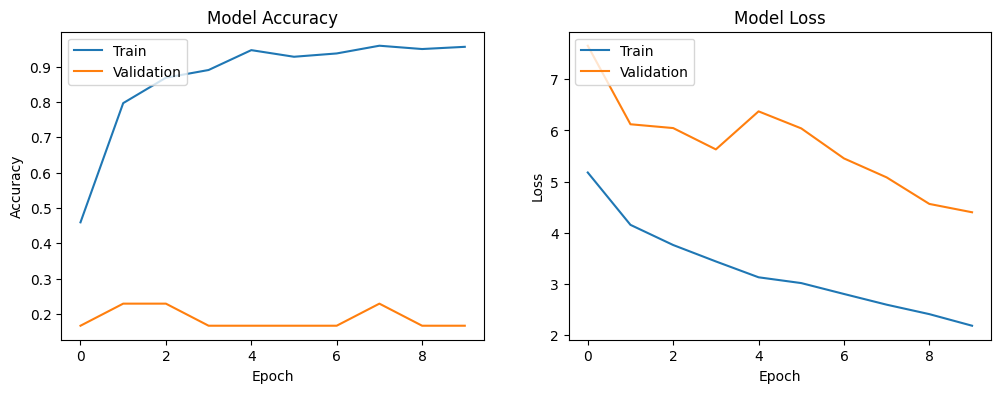

In [11]:
efficientnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = efficientnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    batch_size=32
)
plot_training_history(history)

From result, the traing accuracy of B0 model is extremely high, compared to validation accuracy which is below 0.3. This indicates that the model is extremely overfitting. 

Furthermore, the model loss for both training and validation set are huge, which indicates that the model is not learning from the data.

### Attempt on EfficientnetB7
Per claimed by [this article](https://sahilchachra.medium.com/comparative-study-using-efficientnetb0-to-efficientnetb7-as-encoder-in-unet-a73ec6aeffe8), EfficientnetB7 is the best model among the Efficientnet series. 

However it requires a lot of computational resources and time to train, and my computer is not able to handle it.

### MobileNet
 MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural networks. We will use the MobileNetV2 model for transfer learning.

In [10]:
# Create MobileNet model

mobile_net_model = MobileNetV2(
    include_top=False, 
    weights="imagenet", 
    input_shape=(224, 224, 3), 
    pooling='max'
)

for layer in mobile_net_model.layers:
    layer.trainable = False
    
# Model architecture with advanced regularization

mobile_net_model = Sequential([
    mobile_net_model,
    Flatten(),
    Dense(
        4, 
        activation='softmax'
    )
])

mobile_net_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
I0000 00:00:1740841434.066182    7973 service.cc:148] XLA service 0x7fe270050ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740841434.066823    7973 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-01 23:03:54.197187: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740841434.735587    7973 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:41 11s/step - accuracy: 0.2188 - loss: 6.6753

I0000 00:00:1740841441.501938    7973 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.2503 - loss: 4.7640 - val_accuracy: 0.3750 - val_loss: 2.2573
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 630ms/step - accuracy: 0.5502 - loss: 1.5455 - val_accuracy: 0.5208 - val_loss: 1.7286
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 681ms/step - accuracy: 0.7132 - loss: 1.0143 - val_accuracy: 0.8125 - val_loss: 0.6622
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 661ms/step - accuracy: 0.7760 - loss: 0.7157 - val_accuracy: 0.8125 - val_loss: 0.4886
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 679ms/step - accuracy: 0.8849 - loss: 0.3970 - val_accuracy: 0.7500 - val_loss: 0.6420
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 652ms/step - accuracy: 0.8399 - loss: 0.4998 - val_accuracy: 0.7917 - val_loss: 0.7241
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 632ms/step - accuracy: 0.8877 - loss: 0.3728 - val_accuracy: 0.8750 - val_loss: 0.2528
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.9120 - loss: 0.3036 - val_accuracy: 0.8542 - val_lo

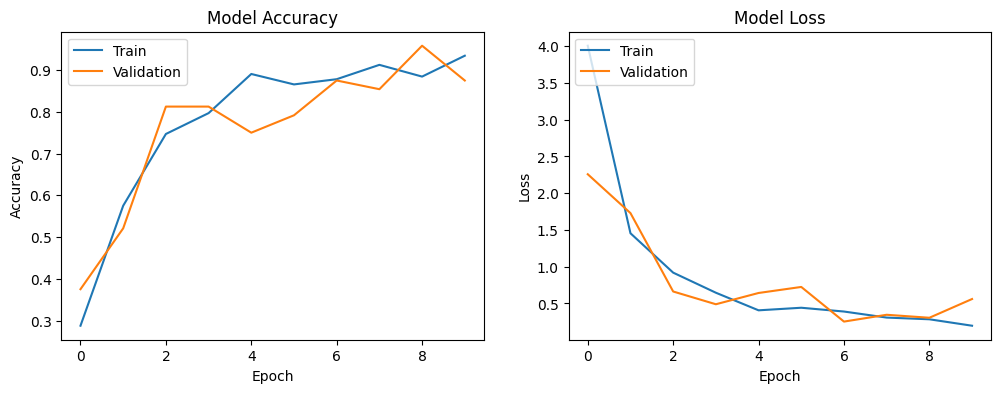

In [11]:
mobile_net_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = mobile_net_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    batch_size=32
)
plot_training_history(history)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - accuracy: 0.9216 - loss: 0.2013 - val_accuracy: 0.8750 - val_loss: 0.3088
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 663ms/step - accuracy: 0.8799 - loss: 0.4190 - val_accuracy: 0.8333 - val_loss: 0.4028
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - accuracy: 0.9334 - loss: 0.1824 - val_accuracy: 0.8542 - val_loss: 0.4273
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 621ms/step - accuracy: 0.9487 - loss: 0.1499 - val_accuracy: 0.8125 - val_loss: 0.3244
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 642ms/step - accuracy: 0.9098 - loss: 0.2513 - val_accuracy: 0.8542 - val_loss: 0.3680
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 669ms/step - accuracy: 0.9422 - loss: 0.1633 - val_accuracy: 0.9583 - val_loss: 0.2295
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 680ms/step - accuracy: 0.9542 - loss: 0.1149 - val_accuracy: 0.9167 - val_loss: 0.2797
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 677ms/step - accuracy: 0.9390 - loss: 0.1841 - val_accuracy: 0.

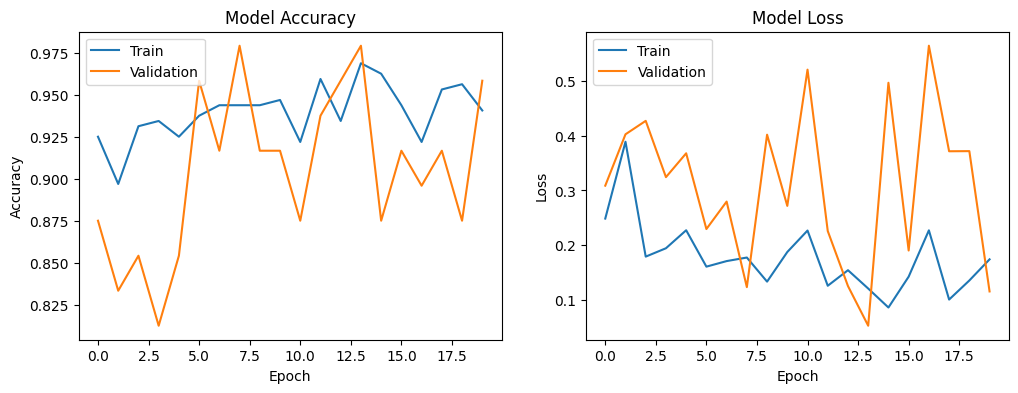

In [12]:
# Test with epoch

history = mobile_net_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    batch_size=32
)
plot_training_history(history)

Per above results, mobileNetV2 model is performing well in both training and validation set. 
In version with Epoch 20, the model loss is always below 1, and the accuracy is above 0.8 in general.
Therefore, we will proceed to test the model with testing set.

### Create early stop to obtain the best model

Epoch 1/20
 2/10 ━━━━━━━━━━━━━━━━━━━━ 4s 505ms/step - accuracy: 0.9453 - loss: 0.2998

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 750ms/step - accuracy: 0.9526 - loss: 0.2035 - val_accuracy: 0.9375 - val_loss: 0.1802
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 686ms/step - accuracy: 0.9653 - loss: 0.0934 - val_accuracy: 0.8750 - val_loss: 0.3336
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 675ms/step - accuracy: 0.9789 - loss: 0.0747 - val_accuracy: 0.8958 - val_loss: 0.2415
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 675ms/step - accuracy: 0.9743 - loss: 0.0792 - val_accuracy: 0.9167 - val_loss: 0.4349
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 671ms/step - accuracy: 0.9558 - loss: 0.1069 - val_accuracy: 0.8750 - val_loss: 0.4664
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 674ms/step - accuracy: 0.9866 - loss: 0.0409 - val_accuracy: 0.9583 - val_loss: 0.0879
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - accuracy: 0.9432 - loss: 0.1912 - val_accuracy: 0.8542 - val_loss: 0.6989
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 645ms/step - accuracy: 0.9476 - loss: 0.1267 - val_accuracy: 0.9583 - val_

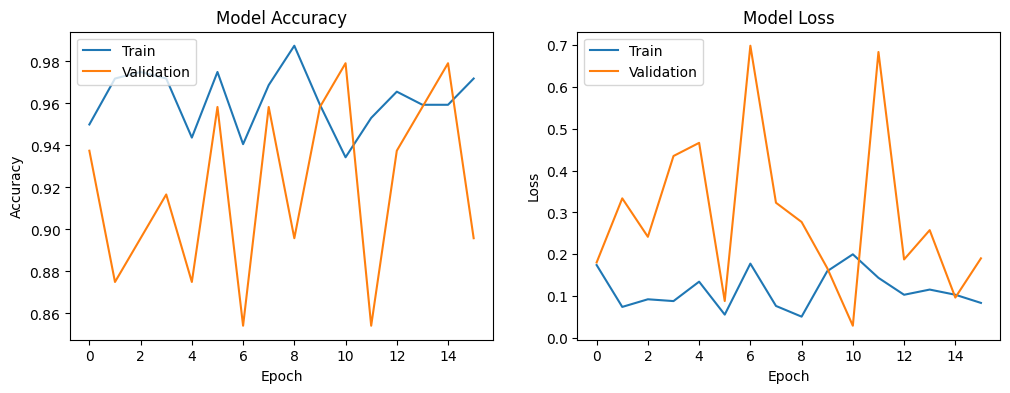

In [14]:
# Earlystop

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = mobile_net_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    batch_size=32,
    callbacks=[early_stopping]
)
plot_training_history(history)

## Testing the model
Now we will input the test data into the model to see how well the model performs on unseen data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
Classification Report:
               precision    recall  f1-score   support

         Bus       0.60      0.86      0.71         7
         Car       1.00      1.00      1.00         7
       Truck       0.86      0.60      0.71        10
  motorcycle       1.00      1.00      1.00         8

    accuracy                           0.84        32
   macro avg       0.86      0.86      0.85        32
weighted avg       0.87      0.84      0.84        32

Confusion Matrix:
 [[6 0 1 0]
 [0 7 0 0]
 [4 0 6 0]
 [0 0 0 8]]


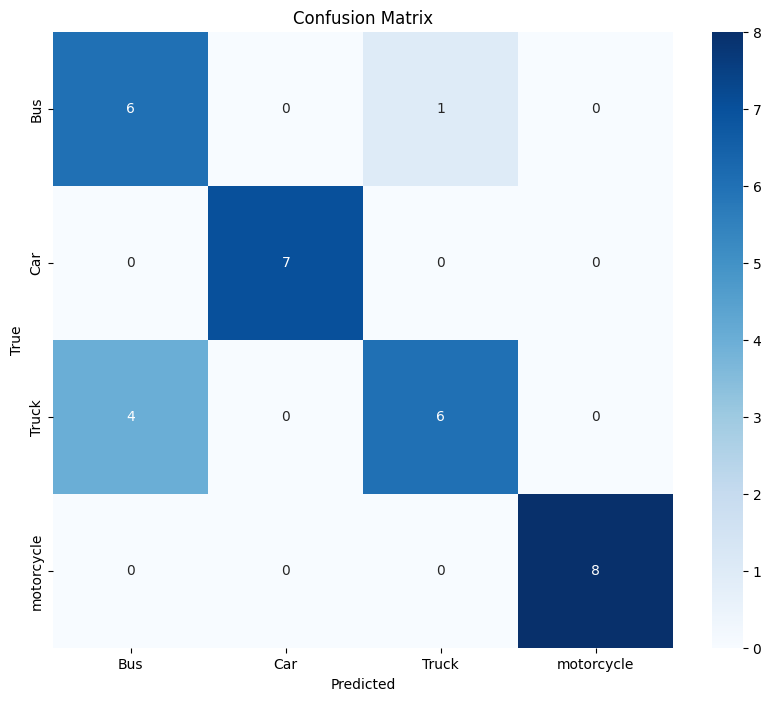

In [15]:
# Generate predictions
test_generator.reset()
predictions = mobile_net_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

From the evaluation metrics, we can see that the MobileNetV2 model is performing well on the test set. The model has an accuracy of 0.84+, which is a good result for this task.

### Model Evaluation and suggested explainations

Why do MobileNetV2 perform better than ResNet50 and EfficientNetB0?
I have performed some research and these are my suggested explainations:
1. ResNet architectures, particularly deeper variants, can be prone to overfitting when trained on smaller datasets. This is due to their complexity and the large number of parameters, which can lead to memorization of the training data rather than generalization to unseen data. In scenarios with limited vehicle images, this can significantly hinder performance. (Source: [Performance Analysis of Deep Convolutional Network Architectures for Classification of Over-Volume Vehicles](https://www.mdpi.com/2076-3417/13/4/2549))
2. EfficientNet employs a compound scaling method that balances depth, width, and resolution. However, if the dataset does not have sufficient diversity or volume, the benefits of this scaling may not be realized, leading to suboptimal performance. (Source: [Image classification: ResNet vs EfficientNet vs EfficientNet_v2 vs Compact Convolutional Transformers](https://medium.com/@enrico.randellini/image-classification-resnet-vs-efficientnet-vs-efficientnet-v2-vs-compact-convolutional-c205838bbf49))
3. MobileNet utilizes depthwise separable convolutions, which significantly reduce the number of parameters and computations required compared to traditional convolutions. This efficiency allows MobileNet to maintain high accuracy while being less prone to overfitting, especially in scenarios with limited data. (Source: [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381))



## Hyper-parameter tuning on MobileNet Model, using Keras Tuner

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    # Base model selection (2 options)
    base_model = keras.applications.MobileNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224, 224, 3)
    )
    
    # Trainable base model option (2 options)
    base_model.trainable = hp.Boolean('base_model_trainable', default=False)
    
    # Create sequential model
    model = keras.Sequential()
    model.add(base_model)
    
    # Pooling layer selection (2 options)
    pooling_type = hp.Choice('pooling', ['global_average', 'flatten'])
    if pooling_type == 'global_average':
        model.add(layers.GlobalAveragePooling2D())
    else:
        model.add(layers.Flatten())
    
    # Dense layers (2 options for number of layers)
    num_dense_layers = hp.Choice('num_dense_layers', [1, 2])
    
    # Dynamic dense layers
    for i in range(num_dense_layers):
        # Units for dense layers (2 options)
        units = hp.Choice(f'units_{i}', [64, 128])
        
        # Activation function (2 options)
        activation = hp.Choice(f'activation_{i}', ['relu', 'elu'])
        
        # Dropout rate (2 options)
        dropout_rate = hp.Choice(f'dropout_{i}', [0.3, 0.5])
        
        model.add(layers.Dense(units, activation=activation))
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(4, activation='softmax'))
    
    # Learning rate (2 options)
    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])
    
    # Optimizer selection (2 options)
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def create_tuner():
    # Create Keras Tuner with RandomSearch
    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=12,  # Reduced trials due to fewer options
        directory='hyperparameter_tuning',
        project_name='image_classification'
    )
    
    return tuner

def perform_hyperparameter_tuning(train_data, val_data):
    # Create tuner
    tuner = create_tuner()
    
    # Print search space summary
    tuner.search_space_summary()
    
    # Perform hyperparameter search
    tuner.search(
        train_data,
        epochs=15,  # Reduced epochs
        validation_data=val_data,
        callbacks=[
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy', 
                patience=3, 
                restore_best_weights=True
            )
        ]
    )
    
    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # Print best hyperparameters
    print("\nBest Hyperparameters:")
    for param, value in best_hps.values.items():
        print(f"{param}: {value}")
    
    # Get best model
    best_model = tuner.get_best_models(num_models=1)[0]
    
    return best_model, best_hps

def final_model_training(best_model, train_data, val_data):
    # Fine-tune the best model
    history = best_model.fit(
        train_data,
        epochs=30,
        validation_data=val_data,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', 
                factor=0.5, 
                patience=2
            ),
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy', 
                patience=5, 
                restore_best_weights=True
            )
        ]
    )
    
    return history

# Perform hyperparameter tuning
best_model, best_hps = perform_hyperparameter_tuning(
    train_generator, 
    validation_generator
)

# Final model training
final_history = final_model_training(
    best_model, 
    train_generator, 
    validation_generator
)

# Evaluate the model
evaluation = best_model.evaluate(validation_generator)
print("\nFinal Model Evaluation:")
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

# Save the best model
best_model.save('best_tuned_model.h5')


Trial 3 Complete [00h 01m 44s]
val_accuracy: 0.9375

Best val_accuracy So Far: 0.9791666865348816
Total elapsed time: 00h 06m 25s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
True              |True              |base_model_trainable
flatten           |global_average    |pooling
1                 |1                 |num_dense_layers
128               |128               |units_0
relu              |elu               |activation_0
0.3               |0.3               |dropout_0
0.001             |0.0001            |learning_rate
rmsprop           |adam              |optimizer
64                |None              |units_1
relu              |None              |activation_1
0.3               |None              |dropout_1

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3323 - loss: 17.2897   

: 

Again, due to resources limitation, my computer can perform the tuning only on a small scale.

Here is the capture of the best tuning result, despite not being able to complete all combinations of hyperparameters.

```
{
         "base_model_trainable":true,
         "pooling":"flatten",
         "num_dense_layers":2,
         "units_0":128,
         "activation_0":"elu",
         "dropout_0":0.5,
         "learning_rate":0.0001,
         "optimizer":"rmsprop",
         "units_1":64,
         "activation_1":"relu",
         "dropout_1":0.3
      }
```


### Perform the best model on testing set
Assume the above parameters are the best, we will perform the model on testing set.

Epoch 1/30
 6/10 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step - accuracy: 0.2884 - loss: 3.6171

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3453 - loss: 3.2347 - val_accuracy: 0.7917 - val_loss: 0.9544 - learning_rate: 1.0000e-04
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 637ms/step - accuracy: 0.5868 - loss: 1.5622 - val_accuracy: 0.6875 - val_loss: 1.0603 - learning_rate: 1.0000e-04
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 754ms/step - accuracy: 0.6784 - loss: 1.1881 - val_accuracy: 0.6458 - val_loss: 1.2244 - learning_rate: 1.0000e-04
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 672ms/step - accuracy: 0.7751 - loss: 0.9941 - val_accuracy: 0.6875 - val_loss: 1.1637 - learning_rate: 1.0000e-04
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 776ms/step - accuracy: 0.7887 - loss: 0.9201 - val_accuracy: 0.8958 - val_loss: 0.5844 - learning_rate: 1.0000e-04
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 610ms/step - accuracy: 0.8559 - loss: 0.8860 - val_accuracy: 0.7292 - val_loss: 1.1871 - learning_rate: 1.0000e-04
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 724ms/step - accuracy: 0.8333 - loss

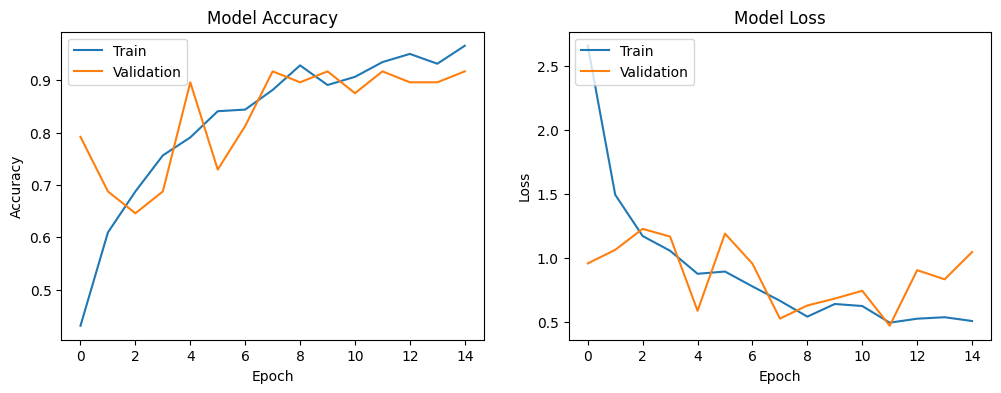

In [8]:
# Base model configuration
mobile_net_model = MobileNetV2(
    include_top=False, 
    weights="imagenet", 
    input_shape=(224, 224, 3), 
    pooling=None  # Explicitly set to None for manual flattening
)

# Set trainability based on hyperparameter
for layer in mobile_net_model.layers:
    layer.trainable = True  # Explicitly set to trainable

# Model architecture with hyperparameter-tuned configuration
mobile_net_model = Sequential([
    mobile_net_model,
    Flatten(),  # Flatten layer as specified
    
    # First dense layer with hyperparameter settings
    Dense(
        units=128,  # 128 units
        activation='elu',  # ELU activation
        kernel_regularizer=l2(0.001)  # Added L2 regularization
    ),
    Dropout(0.5),  # 0.5 dropout rate
    
    # Second dense layer with hyperparameter settings
    Dense(
        units=64,  # 64 units
        activation='relu',  # ReLU activation
        kernel_regularizer=l2(0.001)  # Added L2 regularization
    ),
    Dropout(0.3),  # 0.3 dropout rate
])

# Final output layer
mobile_net_model.add(Dense(
    4, 
    activation='softmax'
))

# Compile with hyperparameter-selected optimizer and learning rate
mobile_net_model.compile(
    optimizer=RMSprop(learning_rate=0.0001),  # RMSprop with 0.0001 learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training with advanced callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=7,  # Slightly increased patience 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=4,  # Adjusted patience 
    min_lr=1e-6  # Slightly lower minimum learning rate
)

# Model training
history = mobile_net_model.fit(
    train_generator,
    epochs=30,  # Increased epochs to allow more learning
    validation_data=validation_generator,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Classification Report:
               precision    recall  f1-score   support

         Bus       1.00      0.86      0.92         7
         Car       1.00      1.00      1.00         7
       Truck       0.91      1.00      0.95        10
  motorcycle       1.00      1.00      1.00         8

    accuracy                           0.97        32
   macro avg       0.98      0.96      0.97        32
weighted avg       0.97      0.97      0.97        32

Confusion Matrix:
 [[ 6  0  1  0]
 [ 0  7  0  0]
 [ 0  0 10  0]
 [ 0  0  0  8]]


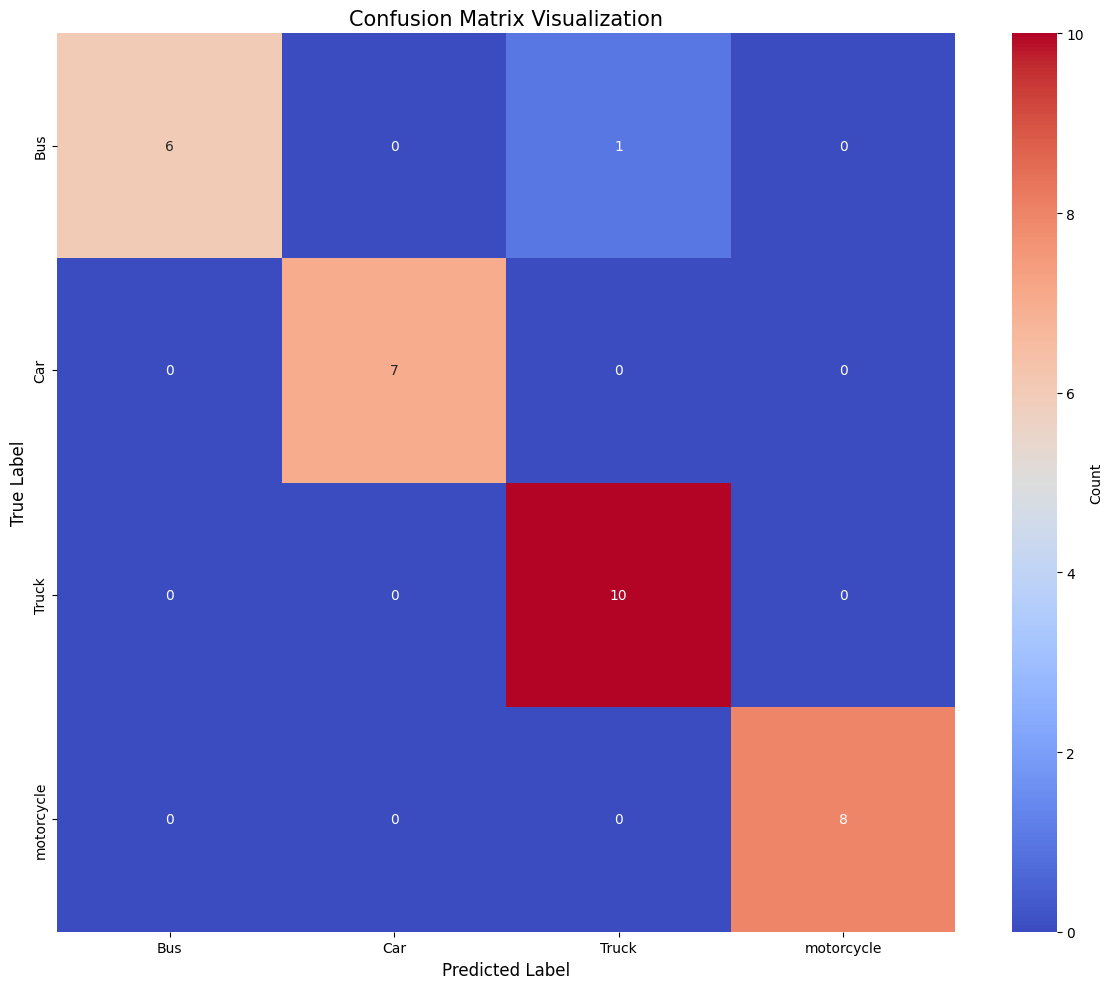

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,028,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,555,466 (78.41 MB)

 Trainable params: 10,260,676 (39.14 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 10,260,678 (39.14 MB)

In [10]:
# Model evaluation
predictions = mobile_net_model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Detailed classification report
report = classification_report(
    true_classes, 
    predicted_classes, 
    target_names=class_labels,
    zero_division=1  # Prevents division by zero warnings
)
print("Classification Report:\n", report)

# Confusion matrix generation and visualization
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

# Enhanced confusion matrix plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='coolwarm', 
    xticklabels=class_labels, 
    yticklabels=class_labels,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix Visualization', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Additional model summary and complexity analysis
mobile_net_model.summary()

From the result above, the model is performing well on the testing set. The model has an accuracy of 0.97+ with excellent precision,recall & f1-score, which is a good result for this task.
Overall it is a huge improvement from the previous MobileNetV2 model.

## Conclusion

In this project, we have explored the application of deep learning in image classification using the Kaggle Vehicle Dataset. We have built a CNN model that can classify images of vehicles into the correct class. We have also experimented with different pre-trained models and compared their performance on the vehicle dataset. 

The MobileNetV2 model has shown the best performance on the vehicle dataset. The model has an accuracy of 0.84+ on the test set, which is a good result for this task. We have also performed hyperparameter tuning on the MobileNetV2 model and achieved an accuracy of 0.97+ on the test set.

Overall, the project has been a great learning experience for me. I have learned a lot about deep learning, image classification, and transfer learning. I have also learned how to build, train, and evaluate CNN models using the Keras library. I hope to continue exploring the field of deep learning and applying it to real-world problems in the future.

## References

1. [Kaggle Vehicle Dataset](https://www.kaggle.com/datasets/kaggleashwin/vehicle-type-recognition/data)
2. [Deep Learning Book by MIT](https://www.deeplearningbook.org/)
3. [Performance Analysis of Deep Convolutional Network Architectures for Classification of Over-Volume Vehicles](https://www.mdpi.com/2076-3417/13/4/2549)
4. [Image classification: ResNet vs EfficientNet vs EfficientNet_v2 vs Compact Convolutional Transformers](https://medium.com/@enrico.randellini/image-classification-resnet-vs-efficientnet-vs-efficientnet-v2-vs-compact-convolutional-c205838bbf49)
5. [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381)
